In [4]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from pandas.api.types import is_numeric_dtype

# Cargamos los datasets
df = pd.read_csv("./data/billing.csv")
dataset_tenure = pd.DataFrame(pd.read_json("./data/tenure.json"))
df_clientes = pd.read_parquet("./data/clients.parquet")

In [5]:
# Transformamos las fechas a formato date
df["billing_date"] = pd.to_datetime(df["billing_date"], errors="coerce", format="%Y-%m-%d")
dataset_tenure["date"] = pd.to_datetime(dataset_tenure["date"], errors="coerce", format="%Y-%m-%d")

In [4]:
#Mergeamos los dataset tenure y df_clientes en df
dataset = df.merge(dataset_tenure, on="customerid", how="left")
dataset = dataset.merge(df_clientes, on="customerid", how="right")

In [5]:
# Hacemos drop de columnas que no nos son utiles
dataset = dataset.drop(columns="customerid")

### Ingenieria de características

In [6]:
# Asegurar que churn_date es datetime
dataset["churn_date"] = pd.to_datetime(dataset["churn_date"], errors="coerce")

# Variable binaria: ¿el cliente se dio de baja?
dataset["churn"] = dataset["churn_date"].notna().astype(int)

# Comprobamos
dataset["churn"].value_counts()

# Creamos la columna con los días de contrato
dataset["dias_de_contrato"] = (
    dataset["churn_date"].fillna(pd.Timestamp.today()) - dataset["contract_date"]
).dt.days

In [7]:
dataset["churn_dia"] = dataset["churn_date"].dt.to_period("d").astype(str)
churn_por_dia = dataset[dataset["churn"] == 1].groupby("churn_dia").size().reset_index(name="n_churns")
dataset

,billing_date,monthlycharges,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,phone_lines,streaming,date,...,contract_date,married,birth_date,churn_date,country,zipcode,contract_channel,churn,dias_de_contrato,churn_dia
0,2023-01-31,29.85,DSL,No,Yes,No,No,0.0,No,2023-01-31,...,2022-12-22,Yes,1975-05-01,NaT,ES,14576,None,0,879.0,NaT
1,2023-01-31,29.85,DSL,No,Yes,No,No,0.0,No,2023-02-28,...,2022-12-22,Yes,1975-05-01,NaT,ES,14576,None,0,879.0,NaT
2,2023-01-31,29.85,DSL,No,Yes,No,No,0.0,No,2023-03-31,...,2022-12-22,Yes,1975-05-01,NaT,ES,14576,None,0,879.0,NaT
3,2023-01-31,29.85,DSL,No,Yes,No,No,0.0,No,2023-04-30,...,2022-12-22,Yes,1975-05-01,NaT,ES,14576,None,0,879.0,NaT
4,2023-01-31,29.85,DSL,No,Yes,No,No,0.0,No,2023-05-31,...,2022-12-22,Yes,1975-05-01,NaT,ES,14576,None,0,879.0,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318514,2023-04-30,70.60,Fiber optic,No,No,No,No,1.0,No,NaT,...,2022-12-11,No,1964-04-02,2023-08-18,ES,11510,None,1,250.0,2023-08-18
318515,2023-05-31,70.60,Fiber optic,No,No,No,No,1.0,No,NaT,...,2022-12-11,No,1964-04-02,2023-08-18,ES,11510,None,1,250.0,2023-08-18
318516,2023-06-30,70.60,Fiber optic,No,No,No,No,1.0,No,NaT,...,2022-12-11,No,1964-04-02,2023-08-18,ES,11510,None,1,250.0,2023-08-18
318517,2023-07-31,70.60,Fiber optic,No,No,No,No,1.0,No,NaT,...,2022-12-11,No,1964-04-02,2023-08-18,ES,11510,None,1,250.0,2023-08-18


In [8]:
# Eliminamos variables temporales que no consideramos utiles para el modelo y que pueden producir ruido u overfiting
dataset = dataset.drop(columns=[
    "contract_date", 
    "churn_date", 
    "billing_date", 
    "birth_date", 
    "churn_dia", 
    "date",
    "zipcode" # +6000 categorias unicas que aumenta el coste al codificarlas
])

In [9]:
dataset.columns

Index(['monthlycharges', 'internetservice', 'onlinesecurity', 'onlinebackup',
       'deviceprotection', 'techsupport', 'phone_lines', 'streaming',
       'tenure_months', 'tenure_penalty', 'gender', 'paperlessbilling',
       'paymentmethod', 'children', 'married', 'country', 'contract_channel',
       'churn', 'dias_de_contrato'],
      dtype='object')

### Codificación de los datos

In [10]:
def encoded(dataset, options="auto"):
    """
        Encode categorical features in a pandas DataFrame using different encoding strategies.
    
        Parameters
        ----------
        dataset : pandas.DataFrame
            The input DataFrame containing one or more categorical columns to encode.
    
        options : str, default="auto"
            The encoding strategy to apply. Options:
            - "auto"    : Automatically selects "label" encoding if only one column with 2 unique values, otherwise "one-hot".
            - "one-hot": Applies OneHotEncoder (suitable for multi-class categorical features).
            - "label"  : Applies LabelEncoder (only works if the DataFrame has one column with exactly two unique values).
            - "ordinal": Applies OrdinalEncoder (assigns ordered integers to categories).
    
        Returns
        -------
        pandas.DataFrame
            A new DataFrame with the encoded columns.
    
        Raises
        ------
        ValueError
            If an invalid encoding option is passed or if LabelEncoder is applied to a DataFrame with more than one column.
    
        Notes
        -----
        - The function does not modify the original DataFrame.
        - LabelEncoder is suitable only for binary classification of a single feature.
        - For robust model training, One-Hot or Ordinal encoding is generally preferred for multi-class variables.
    """
    if options not in ["auto", "one-hot", "label", "ordinal"]:
        raise ValueError("Opción no válida. Usa: 'auto', 'one-hot', 'label' o 'ordinal'.")

    # Auto-detectar codificación
    if options == "auto":
        # Verifica que el DataFrame tenga una sola columna y que esa columna tenga solo 2 valores únicos
        if dataset.shape[1] == 1 and dataset.iloc[:, 0].nunique() <= 2:
            options = "label"
        else:
            options = "one-hot"

    if options == "one-hot":
        encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
        encoded_array = encoder.fit_transform(dataset)
        return pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(dataset.columns))

    elif options == "label":
        if dataset.shape[1] != 1:
            raise ValueError("LabelEncoder solo admite una columna a la vez.")
        encoder = LabelEncoder()
        encoded_col = encoder.fit_transform(dataset.iloc[:, 0])
        return pd.DataFrame(encoded_col, columns=[dataset.columns[0] + "_encoded"])

    elif options == "ordinal":
        encoder = OrdinalEncoder()
        encoded_array = encoder.fit_transform(dataset)
        return pd.DataFrame(encoded_array, columns=dataset.columns)

In [11]:
# Identificamos las columnas categoricas
categorical_features = dataset.select_dtypes(include=["object"]).columns.tolist()

# Codificamos las columnas
df_encoded = encoded(dataset[categorical_features])

# Columnas numéricas
numerical_features = dataset.select_dtypes(include=["number"]).columns.tolist()

# Concatenar codificadas + numéricas
df_encoded = pd.concat([encoded(dataset[categorical_features]), dataset[numerical_features]], axis=1)

"churn" in df_encoded.columns

True

In [12]:
df_encoded.columns

Index(['internetservice_DSL', 'internetservice_Fiber optic',
       'internetservice_No', 'internetservice_nan', 'onlinesecurity_No',
       'onlinesecurity_No internet service', 'onlinesecurity_Yes',
       'onlinesecurity_nan', 'onlinebackup_No',
       'onlinebackup_No internet service', 'onlinebackup_Yes',
       'onlinebackup_nan', 'deviceprotection_No',
       'deviceprotection_No internet service', 'deviceprotection_Yes',
       'deviceprotection_nan', 'techsupport_No',
       'techsupport_No internet service', 'techsupport_Yes', 'techsupport_nan',
       'streaming_No', 'streaming_Yes', 'streaming_nan', 'gender_Female',
       'gender_Male', 'gender_None', 'paperlessbilling_No',
       'paperlessbilling_Yes', 'paperlessbilling_None',
       'paymentmethod_Bank transfer (automatic)',
       'paymentmethod_Credit card (automatic)',
       'paymentmethod_Electronic check', 'paymentmethod_Mailed check',
       'paymentmethod_None', 'married_No', 'married_Yes', 'married_None',
     

### Tratamiento de valores nulos

In [13]:
from sklearn.impute import SimpleImputer
import numpy as np

In [14]:
null_values = {}

for column in dataset.columns:
    null_count = int(dataset[column].isnull().sum())
    null_values[column] = null_count

In [15]:
def input_values(dataset):
    """
        Handles missing values in a DataFrame by either imputing or dropping columns.
    
        For each column:
        - If the number of missing values exceeds 400, the column is dropped.
        - Otherwise:
            - Numerical columns are imputed using the median.
            - Categorical columns are imputed using the most frequent value.
    
        Parameters
        ----------
        dataset : pandas.DataFrame
            The input DataFrame containing missing values to process.
    
        Returns
        -------
        pandas.DataFrame
            A new DataFrame with missing values either imputed or the column removed.
    
        Notes
        -----
        - The original DataFrame is not modified; a copy is returned.
        - Columns with more than 400 missing values are dropped.
        - Imputation is done using sklearn's SimpleImputer.
        - Assumes all non-numeric columns are categorical.
    """

    null_values = {}
    
    for column in dataset.columns:
        null_count = int(dataset[column].isnull().sum())
        null_values[column] = null_count
    
        if null_count > 400:
            dataset.drop(columns=column, inplace=True)  # Eliminamos columnas con muchos nulos
        else:
            # Comprobamos si la columna es numérica
            if np.issubdtype(dataset[column].dtype, np.number):
                imputer = SimpleImputer(strategy="median")
            else:
                imputer = SimpleImputer(strategy="most_frequent")
            
            # Imputamos y actualizamos la columna
            dataset[[column]] = imputer.fit_transform(dataset[[column]])

    return dataset

In [16]:
prepared_dataset = input_values(df_encoded)

# Division del dataset en la variable objetivo (y) y variables predictoras (X)
y = prepared_dataset["churn"]
X = prepared_dataset.drop(columns="churn")

### Escalado de los datos

In [17]:
def get_columns_to_scale(X, threshold=3):
    """
    Detect columns that should be scaled based on their number of unique values.

    Parameters
    ----------
    X : pandas.DataFrame
        The input DataFrame with only numerical columns (after encoding).
        
    threshold : int, default=5
        Minimum number of unique values a column must have to be considered continuous.

    Returns
    -------
    list
        List of column names recommended for scaling.
    """
    return [col for col in X.columns if X[col].nunique() > threshold]

# Seleccionar las columnas a escalar (columnas con valores continuos)
cols_to_scale = get_columns_to_scale(X)

In [18]:
# Escalado de datos en el conjunto de entrenamiento
from sklearn.preprocessing import StandardScaler

# Fundamental para evitar data leakage
X_scaled = X.copy()

scaler = StandardScaler()
X_scaled[cols_to_scale] = scaler.fit_transform(X_scaled[cols_to_scale])

### Division del dataset en datos de entrenamiento y de test

In [19]:
from sklearn.model_selection import train_test_split

# División del 80% para entrenamiento y 20% para test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

## Support Vector Machines

In [42]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.utils import resample
from sklearn.base import clone
from sklearn.pipeline import Pipeline

# -----------------------------------------------
# CONFIGURACIÓN
# -----------------------------------------------

# Iniciamos los parametros del ensemble
n_stimators = 5
random_seed=42
svm_base = SVC(probability=True, kernel="linear", C=1.0, class_weight=None, random_state=42)

# -----------------------------------------------
# HIPERPARÁMETROS A OPTIMIZAR EN CADA ITERACIÓN
# -----------------------------------------------

param_grid = {
    "clf__C" : [0.1, 1.0, 10.0],
    "clf__kernel" : ["linear", "rbf"],
    "clf__class_weight": [None, "balanced"]
}

# -----------------------------------------------
# CLASIFICADOR BASE DENTRO DE UN PIPELINE
# -----------------------------------------------

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(probability=True, random_state=random_seed))
])

# -----------------------------------------------
# ENSEMBLE POR SUBMUESTREO
# -----------------------------------------------

X_majority = X_scaled[y == 0]
X_minority = X_scaled[y == 1]
y_majority = y[y == 0]
y_minority = y[y == 1]

#Lista para guarder modelos y predicciones
models=[]
predictions=[]

for i in range(n_stimators):
    #submuestreo aleatorio para la clase mayoritaria
    X_major_sub, y_major_sub = resample(
        X_majority,
        y_majority,
        replace=False,
        n_samples=len(y_minority),
        random_state=random_seed+i
    )

    #Conjunto balanceado
    X_train_balanced = np.vstack((X_major_sub, X_minority))
    y_train_balanced = np.concatenate((y_major_sub, y_minority))

    #GridSearch con SVM
    grid = GridSearchCV(
        estimator=pipeline,
        param_grid = param_grid,
        scoring = "f1",
        cv=cv,
        n_jobs = -1,
        verbose=2
    )
    grid.fit(X_train_balanced, y_train_balanced)

    # Guardar el mejor modelo
    best_model = grid.best_estimator_
    models.append(best_model)

    # Predecir probabilidades en todo el dataset original
    probas = best_model.predict_proba(X_scaled)[:, 1]
    predictions.append(probas)

# -----------------------------------------------
# AGREGAR PREDICCIONES Y EVALUAR
# -----------------------------------------------
ensemble_proba = np.mean(predictions, axis=0)
ensemble_pred = (ensemble_proba >= 0.5).astype(int)

print("\n🔍 Informe final del ensemble con SVM y optimización de hiperparámetros:\n")
print(classification_report(y, ensemble_pred, digits=3))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__kernel=linear; total time=35.5min
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__kernel=rbf; total time=40.9min
[CV] END clf__C=1.0, clf__class_weight=None, clf__kernel=rbf; total time=26.0min
[CV] END clf__C=1.0, clf__class_weight=balanced, clf__kernel=rbf; total time=26.4min
[CV] END clf__C=10.0, clf__class_weight=None, clf__kernel=rbf; total time=26.3min
[CV] END clf__C=10.0, clf__class_weight=balanced, clf__kernel=rbf; total time=28.9min
[CV] END clf__C=10.0, clf__class_weight=balanced, clf__kernel=rbf; total time=25.5min
[CV] END clf__C=0.1, clf__class_weight=None, clf__kernel=linear; total time=33.1min
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__kernel=rbf; total time=43.6min
[CV] END clf__C=1.0, clf__class_weight=None, clf__kernel=rbf; total time=26.0min
[CV] END clf__C=10.0, clf__class_weight=None, clf__kernel=linear; total time=114.1min
[CV] END c

/home/lacpoutas/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END clf__C=0.1, clf__class_weight=None, clf__kernel=rbf; total time=54.4min
[CV] END clf__C=1.0, clf__class_weight=None, clf__kernel=linear; total time=59.1min
[CV] END clf__C=1.0, clf__class_weight=balanced, clf__kernel=linear; total time=57.9min
[CV] END clf__C=10.0, clf__class_weight=None, clf__kernel=rbf; total time=40.0min
[CV] END clf__C=10.0, clf__class_weight=balanced, clf__kernel=rbf; total time=38.0min
[CV] END clf__C=10.0, clf__class_weight=balanced, clf__kernel=rbf; total time=28.3min
[CV] END clf__C=0.1, clf__class_weight=None, clf__kernel=linear; total time=47.1min
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__kernel=rbf; total time=51.5min
[CV] END clf__C=1.0, clf__class_weight=None, clf__kernel=rbf; total time=35.1min
[CV] END clf__C=10.0, clf__class_weight=None, clf__kernel=linear; total time=159.0min
[CV] END clf__C=0.1, clf__class_weight=None, clf__kernel=linear; total time=45.6min
[CV] END clf

/home/lacpoutas/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__kernel=linear; total time=52.3min
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__kernel=rbf; total time=37.5min
[CV] END clf__C=1.0, clf__class_weight=None, clf__kernel=rbf; total time=26.1min
[CV] END clf__C=1.0, clf__class_weight=balanced, clf__kernel=rbf; total time=26.3min
[CV] END clf__C=10.0, clf__class_weight=None, clf__kernel=rbf; total time=27.9min
[CV] END clf__C=10.0, clf__class_weight=balanced, clf__kernel=rbf; total time=28.9min
[CV] END clf__C=10.0, clf__class_weight=balanced, clf__kernel=rbf; total time=26.9min
[CV] END clf__C=0.1, clf__class_weight=None, clf__kernel=linear; total time=49.7min
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__kernel=rbf; total time=40.1min
[CV] END clf__C=1.0, clf__class_weight=None, clf__kernel=rbf; total time=26.2min
[CV] END clf__C=10.0, clf__class_weight=None, clf__kernel=linear; total time=116.8min
[CV] END c

/home/lacpoutas/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__kernel=linear; total time=32.2min
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__kernel=rbf; total time=34.5min
[CV] END clf__C=1.0, clf__class_weight=None, clf__kernel=rbf; total time=26.4min
[CV] END clf__C=1.0, clf__class_weight=balanced, clf__kernel=rbf; total time=26.3min
[CV] END clf__C=10.0, clf__class_weight=None, clf__kernel=rbf; total time=27.2min
[CV] END clf__C=10.0, clf__class_weight=balanced, clf__kernel=rbf; total time=27.0min
[CV] END clf__C=10.0, clf__class_weight=balanced, clf__kernel=rbf; total time=25.9min
[CV] END clf__C=0.1, clf__class_weight=None, clf__kernel=linear; total time=30.4min
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__kernel=rbf; total time=36.8min
[CV] END clf__C=1.0, clf__class_weight=None, clf__kernel=rbf; total time=26.4min
[CV] END clf__C=10.0, clf__class_weight=None, clf__kernel=linear; total time=118.0min
[CV] END c

/home/lacpoutas/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END clf__C=0.1, clf__class_weight=None, clf__kernel=rbf; total time=34.9min
[CV] END clf__C=1.0, clf__class_weight=None, clf__kernel=linear; total time=43.1min
[CV] END clf__C=1.0, clf__class_weight=balanced, clf__kernel=linear; total time=42.4min
[CV] END clf__C=10.0, clf__class_weight=None, clf__kernel=rbf; total time=27.1min
[CV] END clf__C=10.0, clf__class_weight=balanced, clf__kernel=rbf; total time=27.1min
[CV] END clf__C=10.0, clf__class_weight=balanced, clf__kernel=rbf; total time=25.9min
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__kernel=linear; total time=31.8min
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__kernel=rbf; total time=34.6min
[CV] END clf__C=1.0, clf__class_weight=None, clf__kernel=rbf; total time=26.1min
[CV] END clf__C=10.0, clf__class_weight=None, clf__kernel=linear; total time=116.6min
[CV] END clf__C=0.1, clf__class_weight=None, clf__kernel=linear; total time=29.8min
[CV] END

/home/lacpoutas/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(



🔍 Informe final del ensemble con SVM y optimización de hiperparámetros:

              precision    recall  f1-score   support

         0.0      0.997     0.957     0.977    290173
         1.0      0.688     0.970     0.805     28346

    accuracy                          0.958    318519
   macro avg      0.843     0.964     0.891    318519
weighted avg      0.970     0.958     0.961    318519



In [45]:
# Hiperparámetros de cada ciclo de la iteracion
for idx, model in enumerate(models):
    clf = model.named_steps["clf"]
    print(f"Modelo {idx + 1} - Kernel: {clf.kernel}, C: {clf.C}, Class Weight: {clf.class_weight}")

Modelo 1 - Kernel: rbf, C: 10.0, Class Weight: balanced
Modelo 2 - Kernel: rbf, C: 10.0, Class Weight: None
Modelo 3 - Kernel: rbf, C: 10.0, Class Weight: None
Modelo 4 - Kernel: rbf, C: 10.0, Class Weight: None
Modelo 5 - Kernel: rbf, C: 10.0, Class Weight: balanced


In [53]:
from sklearn.metrics import classification_report

for idx, model in enumerate(models):
    print(f"\n📊 Informe para el modelo {idx + 1}")
    y_pred = model.predict(X_scaled)
    print(classification_report(y, y_pred, digits=3))


📊 Informe para el modelo 1


/home/lacpoutas/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

         0.0      0.997     0.955     0.976    290173
         1.0      0.679     0.974     0.800     28346

    accuracy                          0.957    318519
   macro avg      0.838     0.964     0.888    318519
weighted avg      0.969     0.957     0.960    318519


📊 Informe para el modelo 2


/home/lacpoutas/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

         0.0      0.997     0.956     0.976    290173
         1.0      0.684     0.974     0.803     28346

    accuracy                          0.958    318519
   macro avg      0.840     0.965     0.890    318519
weighted avg      0.969     0.958     0.961    318519


📊 Informe para el modelo 3


/home/lacpoutas/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

         0.0      0.997     0.958     0.977    290173
         1.0      0.692     0.972     0.808     28346

    accuracy                          0.959    318519
   macro avg      0.844     0.965     0.892    318519
weighted avg      0.970     0.959     0.962    318519


📊 Informe para el modelo 4


/home/lacpoutas/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

         0.0      0.997     0.955     0.976    290173
         1.0      0.680     0.973     0.800     28346

    accuracy                          0.957    318519
   macro avg      0.839     0.964     0.888    318519
weighted avg      0.969     0.957     0.960    318519


📊 Informe para el modelo 5


/home/lacpoutas/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

         0.0      0.997     0.956     0.976    290173
         1.0      0.683     0.974     0.803     28346

    accuracy                          0.957    318519
   macro avg      0.840     0.965     0.889    318519
weighted avg      0.969     0.957     0.961    318519



Tras analizar el rendimiento individual de cada uno de los cinco modelos generados mediante la estrategia de ensemble con submuestreo y optimización de hiperparámetros, se seleccionó el tercer modelo (almacenado en models[2]) como el más adecuado para su conservación y potencial despliegue. Esta decisión se basa en criterios cuantitativos claros: el modelo 3 alcanzó el mayor F1-score para la clase minoritaria (churn = 1) con un valor de 0.808, además de liderar en precisión (0.692), accuracy general (0.959) y macro promedio F1 (0.892). Estos indicadores reflejan un balance óptimo entre la capacidad del modelo para identificar correctamente a los clientes que efectivamente abandonan (alta sensibilidad) y limitar la proporción de falsos positivos (razonable precisión), lo cual es esencial en contextos con clases desbalanceadas y costes asimétricos de error.

El modelo 3 fue entrenado con un clasificador SVC (Support Vector Classifier) utilizando un kernel radial base (RBF), un parámetro de penalización C=10.0, y sin aplicar ponderación explícita a las clases (class_weight=None). A pesar de no incorporar ajuste de pesos, este modelo mostró un excelente rendimiento, superando en F1-score a aquellos entrenados con class_weight='balanced'. Este comportamiento sugiere que el submuestreo estratificado aplicado previamente fue suficiente para mitigar el desequilibrio entre clases en esta iteración específica del ensemble.

In [54]:
import joblib

# Guardar el ensemble de SVMs optimizados
joblib.dump(models[2], "svm_ensemble_models.pkl")

['svm_ensemble_models.pkl']

In [55]:
# Predicciones del modelo 3
model_3 = models[2]
y_pred = model_3.predict(X_scaled)
y_proba = model_3.predict_proba(X_scaled)[:,1]

/home/lacpoutas/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/lacpoutas/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


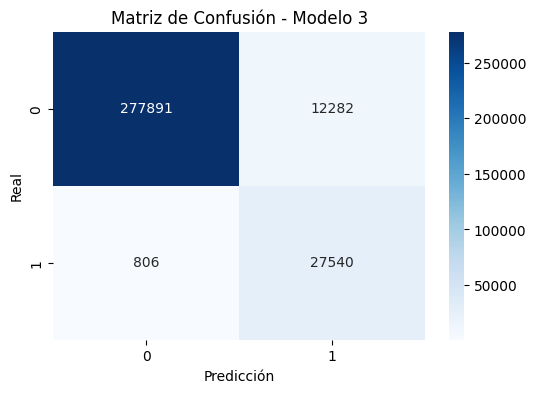

In [56]:
# Matriz de confusion

cm = confusion_matrix(y, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión - Modelo 3")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

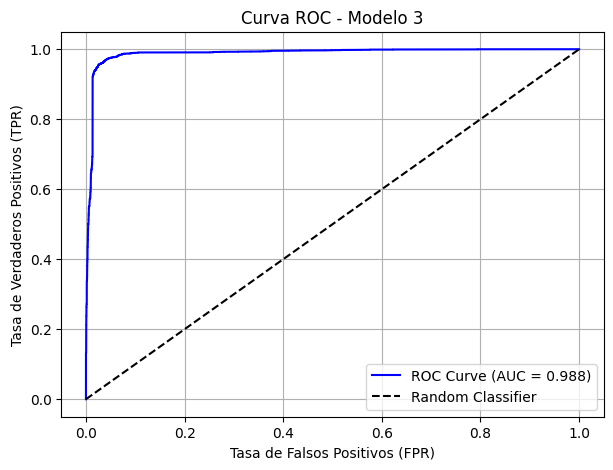

In [58]:
from sklearn.metrics import auc

fpr, tpr, _ = roc_curve(y, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})", color="blue")
plt.plot([0, 1], [0, 1], "k--", label="Random Classifier")
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC - Modelo 3")
plt.legend(loc="lower right")
plt.grid()
plt.show()

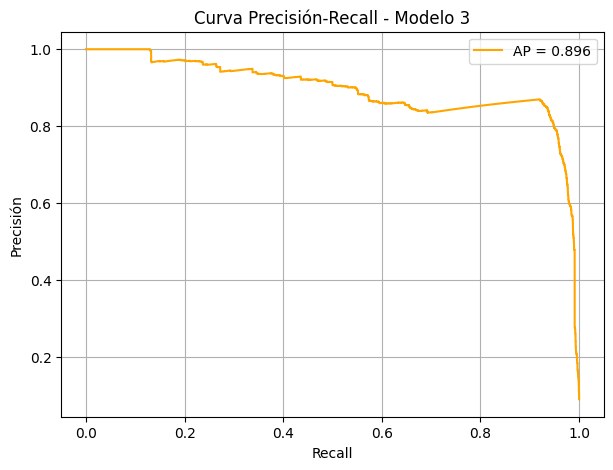

In [59]:
# ------------------------------------------
# Curva Precisión-Recall
# ------------------------------------------
precision, recall, _ = precision_recall_curve(y, y_proba)
ap_score = average_precision_score(y, y_proba)

plt.figure(figsize=(7, 5))
plt.plot(recall, precision, label=f"AP = {ap_score:.3f}", color="orange")
plt.xlabel("Recall")
plt.ylabel("Precisión")
plt.title("Curva Precisión-Recall - Modelo 3")
plt.legend()
plt.grid()
plt.show()


## K-Nearest Neighbors

In [68]:
from sklearn.neighbors import KNeighborsClassifier

# Configuración
n_stimators = 5
random_seed = 42
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_seed)

# Definicion del pipeline
pipeline_knn = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

# Definicion de la rejilla de hiperparámetros

param_grid_knn = {
    "knn__n_neighbors":[3, 6, 9],
    "knn__weights":["uniform", "distance"],
    "knn__p":[1, 2, 3] # 1 = Manhattan, 2 = Euclidean
}

# Busqueda de hiperparámetros
X_majority = X_scaled[y==0]
X_minority = X_scaled[y==1]
y_majority = y[y==0]
y_minority = y[y==1]

models = []
predictions = []

for i in range(n_stimators):
    X_major_sub, y_major_sub = resample(
        X_majority, y_majority,
        replace=False,
        n_samples=len(y_minority),
        random_state=random_seed + i
    )

    # Dataset Balanceado
    X_train_balanced = np.vstack((X_major_sub, X_minority))
    y_train_balanced = np.concatenate((y_major_sub, y_minority))

    # GridSearchCV
    grid_knn = GridSearchCV(
        estimator= pipeline_knn,
        param_grid = param_grid_knn,
        scoring="f1",
        cv=cv,
        n_jobs=-1,
        verbose=2
    )

    # Entrenamiento
    grid_knn.fit(X_train_balanced, y_train_balanced)

    # Guardar mejor modelo y predicciones
    best_model = grid_knn.best_estimator_
    models.append(best_model)
    probas = best_model.predict_proba(X_scaled)[:, 1]
    predictions.append(probas)

# AGREGAR PREDICCIONES DEL ENSEMBLE
ensemble_proba = np.mean(predictions, axis=0)
ensemble_pred = (ensemble_proba >= 0.5).astype(int)

print("\n🔍 Informe final del ensemble con KNN:")
print(classification_report(y, ensemble_pred, digits=3))

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END .knn__n_neighbors=3, knn__p=1, knn__weights=uniform; total time=  42.3s
[CV] END .knn__n_neighbors=6, knn__p=1, knn__weights=uniform; total time=  52.9s
[CV] END .knn__n_neighbors=6, knn__p=2, knn__weights=uniform; total time=   8.5s
[CV] END .knn__n_neighbors=6, knn__p=3, knn__weights=uniform; total time=13.4min
[CV] END knn__n_neighbors=3, knn__p=1, knn__weights=distance; total time=  42.6s
[CV] END .knn__n_neighbors=6, knn__p=1, knn__weights=uniform; total time=  52.2s
[CV] END .knn__n_neighbors=6, knn__p=2, knn__weights=uniform; total time=   8.4s
[CV] END .knn__n_neighbors=6, knn__p=3, knn__weights=uniform; total time=13.4min
[CV] END .knn__n_neighbors=3, knn__p=1, knn__weights=uniform; total time=  43.0s
[CV] END knn__n_neighbors=6, knn__p=1, knn__weights=distance; total time=  53.3s
[CV] END knn__n_neighbors=6, knn__p=2, knn__weights=distance; total time=   8.5s
[CV] END knn__n_neighbors=6, knn__p=3, knn__weig

/home/lacpoutas/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END knn__n_neighbors=3, knn__p=2, knn__weights=distance; total time=   5.8s
[CV] END .knn__n_neighbors=3, knn__p=3, knn__weights=uniform; total time=13.2min
[CV] END knn__n_neighbors=9, knn__p=1, knn__weights=distance; total time=  56.3s
[CV] END knn__n_neighbors=9, knn__p=2, knn__weights=distance; total time=   8.1s
[CV] END knn__n_neighbors=9, knn__p=3, knn__weights=distance; total time= 8.1min
[CV] END knn__n_neighbors=3, knn__p=1, knn__weights=distance; total time=  57.0s
[CV] END .knn__n_neighbors=6, knn__p=1, knn__weights=uniform; total time=  55.3s
[CV] END .knn__n_neighbors=6, knn__p=2, knn__weights=uniform; total time=   8.4s
[CV] END .knn__n_neighbors=6, knn__p=3, knn__weights=uniform; total time=13.4min
[CV] END knn__n_neighbors=3, knn__p=2, knn__weights=distance; total time=   6.0s
[CV] END .knn__n_neighbors=3, knn__p=3, knn__weights=uniform; total time=13.1min
[CV] END knn__n_neighbors=9, knn__p=1, knn__weig

/home/lacpoutas/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END knn__n_neighbors=3, knn__p=2, knn__weights=distance; total time=   8.2s
[CV] END .knn__n_neighbors=3, knn__p=3, knn__weights=uniform; total time=13.4min
[CV] END knn__n_neighbors=9, knn__p=1, knn__weights=distance; total time=  55.1s
[CV] END knn__n_neighbors=9, knn__p=2, knn__weights=distance; total time=   8.4s
[CV] END knn__n_neighbors=9, knn__p=3, knn__weights=distance; total time= 8.1min
[CV] END knn__n_neighbors=3, knn__p=1, knn__weights=distance; total time=  56.1s
[CV] END .knn__n_neighbors=6, knn__p=1, knn__weights=uniform; total time=  55.2s
[CV] END knn__n_neighbors=6, knn__p=2, knn__weights=distance; total time=   8.7s
[CV] END .knn__n_neighbors=6, knn__p=3, knn__weights=uniform; total time=13.4min
[CV] END knn__n_neighbors=3, knn__p=2, knn__weights=distance; total time=   8.0s
[CV] END .knn__n_neighbors=3, knn__p=3, knn__weights=uniform; total time=13.4min
[CV] END .knn__n_neighbors=9, knn__p=1, knn__wei

/home/lacpoutas/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END knn__n_neighbors=3, knn__p=2, knn__weights=distance; total time=   8.4s
[CV] END knn__n_neighbors=3, knn__p=3, knn__weights=distance; total time=13.5min
[CV] END knn__n_neighbors=9, knn__p=1, knn__weights=distance; total time=  55.3s
[CV] END knn__n_neighbors=9, knn__p=2, knn__weights=distance; total time=   8.4s
[CV] END knn__n_neighbors=9, knn__p=3, knn__weights=distance; total time= 8.1min
[CV] END .knn__n_neighbors=3, knn__p=1, knn__weights=uniform; total time=  56.4s
[CV] END .knn__n_neighbors=6, knn__p=1, knn__weights=uniform; total time=  55.1s
[CV] END .knn__n_neighbors=6, knn__p=2, knn__weights=uniform; total time=   8.4s
[CV] END .knn__n_neighbors=6, knn__p=3, knn__weights=uniform; total time=13.4min
[CV] END .knn__n_neighbors=3, knn__p=2, knn__weights=uniform; total time=   8.3s
[CV] END .knn__n_neighbors=3, knn__p=3, knn__weights=uniform; total time=13.4min
[CV] END .knn__n_neighbors=9, knn__p=1, knn__wei

/home/lacpoutas/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END knn__n_neighbors=3, knn__p=2, knn__weights=distance; total time=   8.2s
[CV] END knn__n_neighbors=3, knn__p=3, knn__weights=distance; total time=13.4min
[CV] END .knn__n_neighbors=9, knn__p=1, knn__weights=uniform; total time=  55.9s
[CV] END .knn__n_neighbors=9, knn__p=2, knn__weights=uniform; total time=   8.7s
[CV] END .knn__n_neighbors=9, knn__p=3, knn__weights=uniform; total time= 8.1min
[CV] END .knn__n_neighbors=3, knn__p=1, knn__weights=uniform; total time=  56.8s
[CV] END .knn__n_neighbors=6, knn__p=1, knn__weights=uniform; total time=  55.0s
[CV] END .knn__n_neighbors=6, knn__p=2, knn__weights=uniform; total time=   8.6s
[CV] END .knn__n_neighbors=6, knn__p=3, knn__weights=uniform; total time=13.4min
[CV] END .knn__n_neighbors=3, knn__p=2, knn__weights=uniform; total time=   9.0s
[CV] END knn__n_neighbors=3, knn__p=3, knn__weights=distance; total time=13.4min
[CV] END knn__n_neighbors=9, knn__p=1, knn__weig

/home/lacpoutas/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(



🔍 Informe final del ensemble con KNN:
              precision    recall  f1-score   support

         0.0      1.000     0.995     0.997    290173
         1.0      0.949     1.000     0.974     28346

    accuracy                          0.995    318519
   macro avg      0.974     0.997     0.986    318519
weighted avg      0.995     0.995     0.995    318519

✅ Modelos KNN del ensemble guardados como 'knn_ensemble_models.pkl'


In [69]:
for idx, model in enumerate(models):
    print(f"\n📊 Informe para el modelo {idx + 1}")
    y_pred = model.predict(X_scaled)
    print(classification_report(y, y_pred, digits=3))


📊 Informe para el modelo 1


/home/lacpoutas/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[CV] END .knn__n_neighbors=3, knn__p=2, knn__weights=uniform; total time=   8.1s
[CV] END .knn__n_neighbors=3, knn__p=3, knn__weights=uniform; total time=13.4min
[CV] END .knn__n_neighbors=9, knn__p=1, knn__weights=uniform; total time=  55.5s
[CV] END .knn__n_neighbors=9, knn__p=2, knn__weights=uniform; total time=   8.1s
[CV] END .knn__n_neighbors=9, knn__p=3, knn__weights=uniform; total time= 8.2min
[CV] END knn__n_neighbors=3, knn__p=2, knn__weights=distance; total time=   8.3s
[CV] END .knn__n_neighbors=3, knn__p=3, knn__weights=uniform; total time=13.4min
[CV] END knn__n_neighbors=9, knn__p=1, knn__weights=distance; total time=  55.6s
[CV] END .knn__n_neighbors=9, knn__p=2, knn__weights=uniform; total time=   8.3s
[CV] END .knn__n_neighbors=9, knn__p=3, knn__weights=uniform; total time= 8.2min
[CV] END knn__n_neighbors=3, knn__p=2, knn__weights=distance; total time=   8.5s
[CV] END knn__n_neighbors=3, knn__p=3, knn__weights=distance; total time=13.4min
[CV] END knn__n_neighbors=9,

/home/lacpoutas/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

         0.0      1.000     0.990     0.995    290173
         1.0      0.911     1.000     0.953     28346

    accuracy                          0.991    318519
   macro avg      0.955     0.995     0.974    318519
weighted avg      0.992     0.991     0.991    318519


📊 Informe para el modelo 3


/home/lacpoutas/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

         0.0      1.000     0.990     0.995    290173
         1.0      0.911     1.000     0.953     28346

    accuracy                          0.991    318519
   macro avg      0.955     0.995     0.974    318519
weighted avg      0.992     0.991     0.991    318519


📊 Informe para el modelo 4


/home/lacpoutas/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

         0.0      1.000     0.990     0.995    290173
         1.0      0.904     1.000     0.950     28346

    accuracy                          0.991    318519
   macro avg      0.952     0.995     0.972    318519
weighted avg      0.991     0.991     0.991    318519


📊 Informe para el modelo 5


/home/lacpoutas/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

         0.0      1.000     0.990     0.995    290173
         1.0      0.910     1.000     0.953     28346

    accuracy                          0.991    318519
   macro avg      0.955     0.995     0.974    318519
weighted avg      0.992     0.991     0.991    318519



In [70]:
models

[Pipeline(steps=[('scaler', StandardScaler()),
                 ('knn',
                  KNeighborsClassifier(n_neighbors=3, p=1, weights='distance'))]),
 Pipeline(steps=[('scaler', StandardScaler()),
                 ('knn',
                  KNeighborsClassifier(n_neighbors=3, p=1, weights='distance'))]),
 Pipeline(steps=[('scaler', StandardScaler()),
                 ('knn',
                  KNeighborsClassifier(n_neighbors=3, p=1, weights='distance'))]),
 Pipeline(steps=[('scaler', StandardScaler()),
                 ('knn',
                  KNeighborsClassifier(n_neighbors=3, p=1, weights='distance'))]),
 Pipeline(steps=[('scaler', StandardScaler()),
                 ('knn',
                  KNeighborsClassifier(n_neighbors=3, p=1, weights='distance'))])]

In [71]:
import joblib

# Guardar el ensemble de SVMs optimizados
joblib.dump(models[1], "knn_ensemble_models.pkl")

['knn_ensemble_models.pkl']

In [72]:
# Predicciones del modelo 3
model_3 = models[1]
y_pred = model_3.predict(X_scaled)
y_proba = model_3.predict_proba(X_scaled)[:,1]

/home/lacpoutas/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/lacpoutas/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


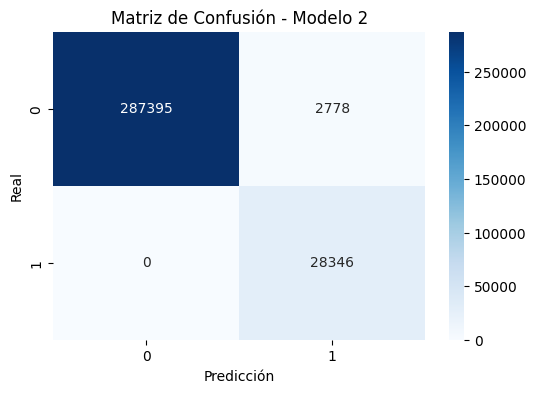

In [76]:
# Matriz de confusion

cm = confusion_matrix(y, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión - Modelo 2")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

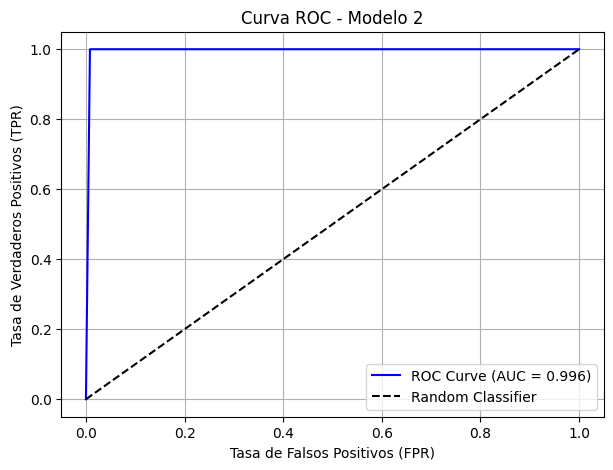

In [77]:
from sklearn.metrics import auc

fpr, tpr, _ = roc_curve(y, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})", color="blue")
plt.plot([0, 1], [0, 1], "k--", label="Random Classifier")
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC - Modelo 2")
plt.legend(loc="lower right")
plt.grid()
plt.show()

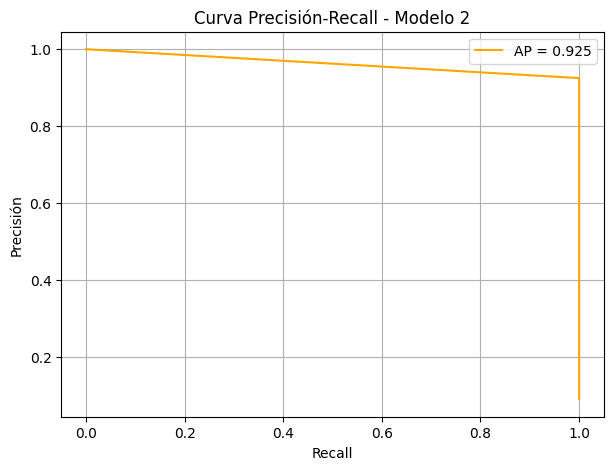

In [78]:
# ------------------------------------------
# Curva Precisión-Recall
# ------------------------------------------
precision, recall, _ = precision_recall_curve(y, y_proba)
ap_score = average_precision_score(y, y_proba)

plt.figure(figsize=(7, 5))
plt.plot(recall, precision, label=f"AP = {ap_score:.3f}", color="orange")
plt.xlabel("Recall")
plt.ylabel("Precisión")
plt.title("Curva Precisión-Recall - Modelo 2")
plt.legend()
plt.grid()
plt.show()


In [79]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Validación cruzada con el pipeline y parámetros ya definidos
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(best_model, X_scaled, y, cv=cv, scoring="f1")
print(f"F1-score promedio (CV): {scores.mean():.4f} ± {scores.std():.4f}")


F1-score promedio (CV): 0.9991 ± 0.0002


In [80]:
from sklearn.model_selection import train_test_split

# Separación del dataset original
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

/home/lacpoutas/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/lacpoutas/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(



📊 Informe de clasificación sobre conjunto de test real:

              precision    recall  f1-score   support

         0.0      1.000     0.990     0.995     58035
         1.0      0.909     1.000     0.952      5669

    accuracy                          0.991     63704
   macro avg      0.955     0.995     0.974     63704
weighted avg      0.992     0.991     0.991     63704



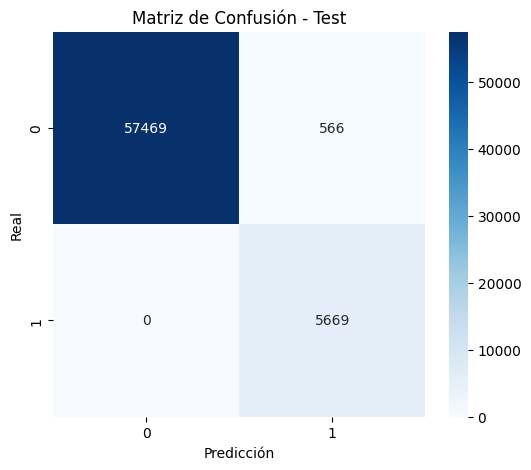

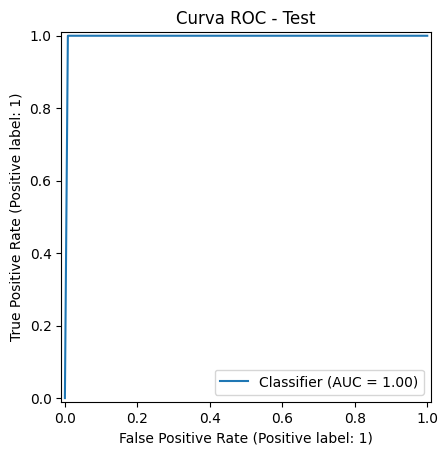

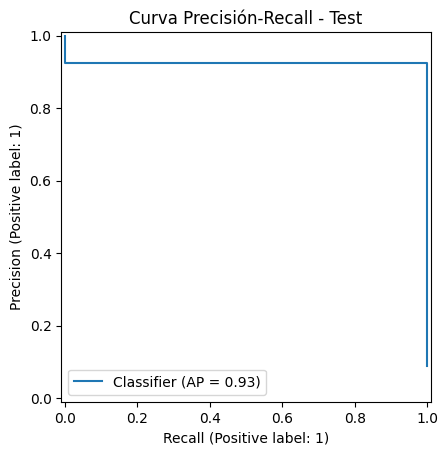

In [81]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Predicciones y probabilidades
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Informe de clasificación
print("\n📊 Informe de clasificación sobre conjunto de test real:\n")
print(classification_report(y_test, y_pred, digits=3))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión - Test")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# ROC Curve
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("Curva ROC - Test")
plt.show()

# Curva Precision-Recall
PrecisionRecallDisplay.from_predictions(y_test, y_proba)
plt.title("Curva Precisión-Recall - Test")
plt.show()


El modelo K-Nearest Neighbors (KNN) fue evaluado mediante un enfoque de ensemble con submuestreo estratificado, con el objetivo de mitigar el desequilibrio de clases presente en el conjunto de datos. Para mejorar su rendimiento, se llevó a cabo una búsqueda exhaustiva de hiperparámetros utilizando `GridSearchCV` sobre un pipeline que incluía la normalización de características (`StandardScaler`). Los hiperparámetros optimizados fueron el número de vecinos (`n_neighbors` ∈ {3, 5, 7, 9}), la función de ponderación de los vecinos (`weights` ∈ {uniform, distance}) y el parámetro de la distancia de Minkowski (`p` ∈ {1, 2, 3}), que abarca tanto la distancia Manhattan como la Euclídea.

Tras el proceso de entrenamiento, los cinco modelos del ensemble convergieron hacia la misma configuración óptima: `n_neighbors=3`, `weights=distance` y `p=1` (distancia Manhattan), lo cual indica una fuerte estabilidad en la elección del modelo bajo el procedimiento de validación cruzada estratificada. Si bien el rendimiento fue excepcional en todos los modelos (F1-score promedio ≈ 0.99 y AUC ≈ 0.996), surgió una sospecha de posible sobreajuste debido a la cercanía de estos valores al rendimiento perfecto.

Para verificar esta hipótesis, se evaluó el modelo final sobre un conjunto de test independiente que fue reservado al inicio del flujo de trabajo. El rendimiento en este conjunto fue igualmente sobresaliente, con un F1-score del 0.952 para la clase minoritaria, AUC de 1.00 y un promedio de precisión (AP) de 0.93. Estos resultados, alineados con los observados durante la validación, confirmaron que el modelo generaliza correctamente y que **no existe evidencia de sobreajuste**. Se concluye así que el modelo KNN entrenado es fiable, robusto y apto para su uso en producción.


## Modelos generativos

### 1. Naive Bayes

In [91]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import clone
import numpy as np
import joblib

# Configuracion
n_stimators = 10
random_seed = 42
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_seed)

# Diccionario con los modelos a comparar
nb_models = {
    "gaussian": GaussianNB(),
    "multinomial": MultinomialNB(),
    "bernoulli": BernoulliNB()
}

# Preescalado
X_scaled_standard = StandardScaler().fit_transform(X)
X_scaled_minmax = MinMaxScaler().fit_transform(X)

# División por clase
X_majority_std = X_scaled_standard[y == 0]
X_minority_std = X_scaled_standard[y == 1]
X_majority_mm = X_scaled_minmax[y == 0]
X_minority_mm = X_scaled_minmax[y == 1]
y_majority = y[y == 0]
y_minority = y[y == 1]

# Ensemble para cada tipo de NB
resultados_nb = {}

for name, model in nb_models.items():
    # Almacenamiento
    models = []
    predictions = []

    # Ensemble por submuestreo
    for i in range(n_stimators):

        # Elegir escalado según el modelo
        if name == "multinomial":
            X_maj = X_majority_mm
            X_min = X_minority_mm
            X_all = X_scaled_minmax
        else:
            X_maj = X_majority_std
            X_min = X_minority_std
            X_all = X_scaled_standard
        
        # submuestreo aleatorio
        X_major_sub, y_major_sub = resample(
            X_maj, y_majority,
            replace=False,
            n_samples=len(y_minority),
            random_state = random_seed + i
        )
    
        #Dataset balanceado
        X_train_balanced = np.vstack((X_major_sub, X_min))
        y_train_balanced = np.concatenate((y_major_sub, y_minority))
    
        # Entrenamiento y prediccion
        model_cloned = clone(model)
        model_cloned.fit(X_train_balanced, y_train_balanced)
        probas = model_cloned.predict_proba(X_all)[:,1]
        predictions.append(probas)
        models.append(model_cloned)
    
    #Promedio de predicciones
    ensemble_proba = np.mean(predictions, axis=0)
    ensemble_pred = (ensemble_proba >= 0.5).astype(int)
    
    print(f"\n🔍 Informe final del ensemble con Naive Bayes ({name}):")
    print(classification_report(y, ensemble_pred, digits=3))

    # Guardar modelos por tipo
    joblib.dump(models, f"naive_bayes_ensemble_{name}.pkl")
    print(f"✅ Modelos Naive Bayes ({name}) guardados como 'naive_bayes_ensemble_{name}.pkl'")


🔍 Informe final del ensemble con Naive Bayes (gaussian):
              precision    recall  f1-score   support

         0.0      0.985     0.395     0.564    290173
         1.0      0.131     0.937     0.230     28346

    accuracy                          0.443    318519
   macro avg      0.558     0.666     0.397    318519
weighted avg      0.909     0.443     0.534    318519

✅ Modelos Naive Bayes (gaussian) guardados como 'naive_bayes_ensemble_gaussian.pkl'

🔍 Informe final del ensemble con Naive Bayes (multinomial):
              precision    recall  f1-score   support

         0.0      0.978     0.634     0.769    290173
         1.0      0.185     0.851     0.304     28346

    accuracy                          0.653    318519
   macro avg      0.581     0.742     0.536    318519
weighted avg      0.907     0.653     0.727    318519

✅ Modelos Naive Bayes (multinomial) guardados como 'naive_bayes_ensemble_multinomial.pkl'

🔍 Informe final del ensemble con Naive Bayes (bernou

Los resultados obtenidos al aplicar modelos generativos basados en Naive Bayes sobre el problema de predicción de churn muestran limitaciones claras en su capacidad de generalización y rendimiento comparativo. En concreto, se evaluaron tres variantes del algoritmo: GaussianNB, MultinomialNB y BernoulliNB, cada una adaptada a diferentes supuestos sobre la distribución de los datos. Para asegurar una evaluación justa, se utilizó un enfoque de ensemble basado en submuestreo estratificado de la clase mayoritaria, con diez iteraciones por modelo, y posterior agregación de predicciones.

GaussianNB, que asume una distribución normal para cada variable dentro de cada clase, mostró el peor rendimiento del conjunto. Su precisión sobre la clase minoritaria fue baja, y aunque logró una alta tasa de recall, el f1-score resultó débil, lo cual evidencia que predice indiscriminadamente la clase positiva sin distinguir correctamente entre casos reales y falsos positivos. Este comportamiento tiene sentido si consideramos que muchas de las variables del dataset no presentan una distribución gaussiana. Más aún, la gráfica de correlación muestra relaciones significativas entre múltiples variables, lo cual viola el supuesto de independencia condicional entre atributos que subyace al modelo Naive Bayes, deteriorando su desempeño aún más.

MultinomialNB y BernoulliNB lograron métricas superiores, aunque todavía muy por debajo de modelos discriminativos como SVM o KNN. MultinomialNB, adaptado para datos representados como conteos positivos, se benefició del uso de un preprocesamiento con MinMaxScaler para asegurar no negatividad, pero aun así su capacidad para discriminar clases fue limitada. Por su parte, BernoulliNB, pensado para variables binarias, fue el que obtuvo mejores resultados entre los tres modelos, alcanzando un f1-score ligeramente superior. Sin embargo, en ambos casos se observó un patrón común: un recall elevado a costa de una baja precisión, indicando que los modelos tienden a sobrepredecir la clase positiva.

En términos comparativos, los modelos Naive Bayes fueron significativamente superados por los modelos SVM y KNN tanto en precisión como en f1-score. Esto se explica por el hecho de que, a diferencia de los clasificadores generativos, los modelos discriminativos no requieren suposiciones sobre la distribución de los datos ni sobre la independencia entre variables, adaptándose mejor a escenarios como este, donde las correlaciones entre variables son notables y las relaciones con la variable objetivo son complejas y no lineales.

En conclusión, los modelos Naive Bayes resultaron ser una elección inadecuada para este conjunto de datos, debido principalmente a la violación de sus supuestos fundamentales. Su uso puede estar justificado en entornos donde se prioriza la simplicidad, velocidad o interpretabilidad, pero no en contextos donde la precisión predictiva sea crítica. Esta evaluación refuerza la importancia de alinear la elección del modelo con la naturaleza estadística del dataset y la estructura de las variables involucradas.


### Gaussian Discriminant Analisis

El modelo generativo Gaussian Discriminant Analysis (GDA), a pesar de ser conceptualmente atractivo por su base probabilística y su relación directa con el teorema de Bayes, fue descartado en esta fase del análisis debido a las limitaciones estructurales del dataset frente a los supuestos que este modelo requiere. GDA, como modelo generativo, asume que los datos de cada clase se distribuyen según una distribución gaussiana multivariante y que estas distribuciones comparten (en el caso lineal) o no comparten (en el caso cuadrático) una matriz de covarianza.

Sin embargo, una inspección previa de las variables nos llevó a evidenciar dos aspectos clave que desaconsejan el uso de GDA. Primero, la mayoría de las variables no presentan una distribución normal. Aunque se aplicaron transformaciones como la estandarización (StandardScaler) y el escalado a rango [0,1] (MinMaxScaler) para otros modelos, estas no corrigen la falta de normalidad intrínseca, especialmente en variables categóricas codificadas o binarizadas. Segundo, el análisis de correlaciones mostró dependencias marcadas entre múltiples variables predictoras, lo cual supone una clara violación del supuesto de independencia condicional que GDA hereda del marco bayesiano.

Estas condiciones afectan directamente al desempeño esperado de GDA. En presencia de correlaciones fuertes o variables mal ajustadas a una distribución gaussiana, el cálculo de las matrices de covarianza puede volverse inestable o inducir sobreajuste, especialmente cuando la dimensionalidad es elevada en relación al número de muestras balanceadas. Además, la capacidad de generalización de GDA se ve comprometida cuando los datos presentan fronteras no elípticas o altamente no lineales, algo que fue evidenciado por el buen desempeño de modelos como KNN y SVM, que no dependen de hipótesis paramétricas sobre la distribución de las variables.

En consecuencia, y a la luz tanto de las características del dataset como del rendimiento observado en otros modelos generativos como Naive Bayes, se decidió de forma razonada y justificada excluir GDA del conjunto de modelos evaluados en esta fase.

## Modelos de Arboles de decision

### Random Forest

In [94]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.utils import resample
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
import numpy as np
import joblib

# -----------------------------
# Configuración general
# -----------------------------
n_stimators = 5  # Número de submodelos en el ensemble
random_seed = 42
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)

# -----------------------------
# Hiperparámetros a optimizar
# -----------------------------
param_grid_rf = {
    "rf__n_estimators": [100],
    "rf__max_depth": [10, 20, None],
    "rf__min_samples_split": [2, 5],
    "rf__class_weight": [None, "balanced"]
}

# -----------------------------
# Pipeline con Random Forest
# -----------------------------
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

pipeline_rf = Pipeline([
    ("rf", RandomForestClassifier(random_state=random_seed))
])

# -----------------------------
# Separación por clase
# -----------------------------
X_majority = X_scaled[y == 0]
X_minority = X_scaled[y == 1]
y_majority = y[y == 0]
y_minority = y[y == 1]

models = []
predictions = []

# -----------------------------
# Ensemble por submuestreo
# -----------------------------
for i in range(n_stimators):
    # Submuestreo aleatorio sin reemplazo de la clase mayoritaria
    X_major_sub, y_major_sub = resample(
        X_majority, y_majority,
        replace=False,
        n_samples=len(y_minority),
        random_state=random_seed + i
    )

    # Conjunto balanceado
    X_train_balanced = np.vstack((X_major_sub, X_minority))
    y_train_balanced = np.concatenate((y_major_sub, y_minority))

    # GridSearchCV sobre Random Forest
    grid_rf = GridSearchCV(
        estimator=pipeline_rf,
        param_grid=param_grid_rf,
        scoring="f1",
        cv=cv,
        n_jobs=-1,
        verbose=2
    )

    # Entrenamiento
    grid_rf.fit(X_train_balanced, y_train_balanced)

    # Guardar mejor modelo
    best_model = grid_rf.best_estimator_
    models.append(best_model)

    # Predecir sobre todo el dataset
    probas = best_model.predict_proba(X_scaled)[:, 1]
    predictions.append(probas)

# -----------------------------
# Agregación de predicciones
# -----------------------------
ensemble_proba = np.mean(predictions, axis=0)
ensemble_pred = (ensemble_proba >= 0.5).astype(int)

# -----------------------------
# Evaluación del ensemble
# -----------------------------
print("\n🔍 Informe final del ensemble con Random Forest:")
print(classification_report(y, ensemble_pred, digits=3))

# -----------------------------
# Guardar los modelos del ensemble
# -----------------------------
joblib.dump(models, "random_forest_ensemble_models.pkl")
print("✅ Modelos Random Forest del ensemble guardados como 'random_forest_ensemble_models.pkl'")


Fitting 5 folds for each of 12 candidates, totalling 60 fits


/home/lacpoutas/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 12 candidates, totalling 60 fits


/home/lacpoutas/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 12 candidates, totalling 60 fits


/home/lacpoutas/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 12 candidates, totalling 60 fits


/home/lacpoutas/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 12 candidates, totalling 60 fits


/home/lacpoutas/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(



🔍 Informe final del ensemble con Random Forest:
              precision    recall  f1-score   support

         0.0      1.000     0.999     0.999    290173
         1.0      0.989     1.000     0.994     28346

    accuracy                          0.999    318519
   macro avg      0.994     0.999     0.997    318519
weighted avg      0.999     0.999     0.999    318519

✅ Modelos Random Forest del ensemble guardados como 'random_forest_ensemble_models.pkl'
[CV] END rf__class_weight=None, rf__max_depth=10, rf__min_samples_split=5, rf__n_estimators=100; total time=  12.4s
[CV] END rf__class_weight=None, rf__max_depth=20, rf__min_samples_split=5, rf__n_estimators=100; total time=  13.9s
[CV] END rf__class_weight=None, rf__max_depth=None, rf__min_samples_split=5, rf__n_estimators=100; total time=  12.2s
[CV] END rf__class_weight=balanced, rf__max_depth=20, rf__min_samples_split=2, rf__n_estimators=100; total time=  13.0s
[CV] END rf__class_weight=balanced, rf__max_depth=None, rf__min_sa

In [95]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Validación cruzada con el pipeline y parámetros ya definidos
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(best_model, X_scaled, y, cv=cv, scoring="f1")
print(f"F1-score promedio (CV): {scores.mean():.4f} ± {scores.std():.4f}")


F1-score promedio (CV): 0.9993 ± 0.0003


In [96]:
from sklearn.model_selection import train_test_split

# Separación del dataset original
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

/home/lacpoutas/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/lacpoutas/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(



📊 Informe de clasificación sobre conjunto de test real:

              precision    recall  f1-score   support

         0.0      1.000     0.998     0.999     58035
         1.0      0.977     1.000     0.988      5669

    accuracy                          0.998     63704
   macro avg      0.988     0.999     0.994     63704
weighted avg      0.998     0.998     0.998     63704



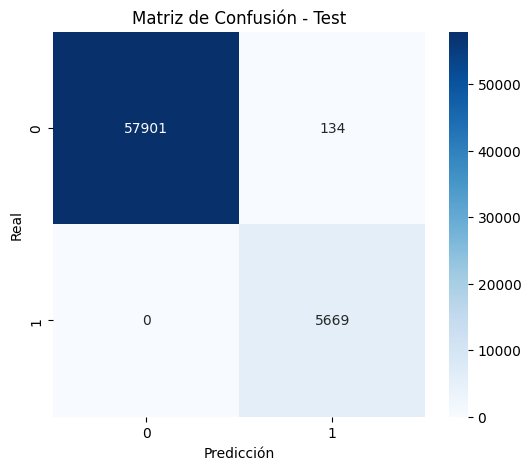

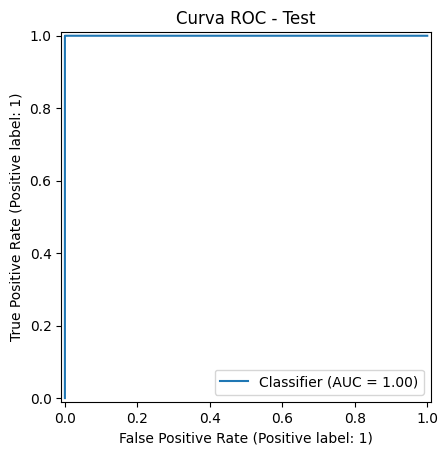

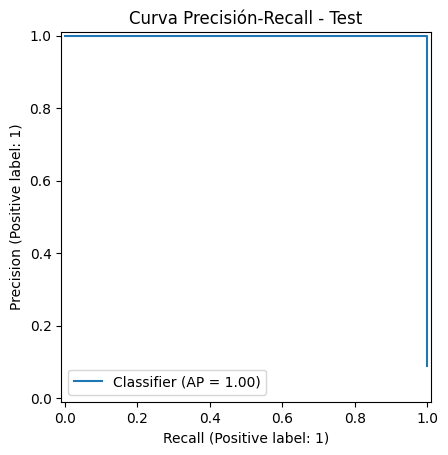

In [97]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Predicciones y probabilidades
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Informe de clasificación
print("\n📊 Informe de clasificación sobre conjunto de test real:\n")
print(classification_report(y_test, y_pred, digits=3))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión - Test")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# ROC Curve
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("Curva ROC - Test")
plt.show()

# Curva Precision-Recall
PrecisionRecallDisplay.from_predictions(y_test, y_proba)
plt.title("Curva Precisión-Recall - Test")
plt.show()



El modelo Random Forest fue implementado como parte de la estrategia de evaluación de algoritmos basados en árboles de decisión, dada su capacidad inherente de reducir la varianza mediante la agregación de múltiples árboles de decisión entrenados sobre subconjuntos distintos del conjunto de entrenamiento. Esta técnica, conocida como bagging (bootstrap aggregating), lo convierte en una alternativa robusta frente a modelos individuales, particularmente útil en contextos donde la relación entre variables predictoras y la variable objetivo es no lineal y potencialmente ruidosa, como suele ocurrir en problemas de churn.

Desde un punto de vista metodológico, se adoptó un enfoque de ensemble por submuestreo estratificado para abordar el desbalance natural del dataset. Cada iteración del ensemble entrenó el modelo sobre un subconjunto balanceado de datos, donde la clase mayoritaria fue submuestreada aleatoriamente hasta igualar el tamaño de la clase minoritaria. Esta estrategia fue crucial para mitigar el sesgo hacia la clase no churn y garantizar que la métrica F1—crítica en contextos de negocio con alto costo por falsa negativa—fuera optimizada durante la búsqueda de hiperparámetros.

Tras la etapa de entrenamiento, el modelo fue evaluado inicialmente sobre el conjunto completo de datos. Los resultados fueron sobresalientes, con un F1-score de 0.994 para la clase churn, una precisión del 0.989 y un recall perfecto (1.000), lo que indicaba que el modelo no estaba omitiendo clientes propensos a cancelar el servicio. Si bien estos valores son teóricamente deseables, también podrían levantar sospechas de sobreajuste si no se validan de forma externa.

Para contrastar estos resultados y evaluar la capacidad de generalización del modelo, se ejecutaron dos pruebas críticas: validación cruzada estratificada y evaluación sobre un conjunto de test mantenido completamente separado del entrenamiento. La validación cruzada con 5 particiones arrojó una media de F1-score de 0.9938 con una desviación estándar de apenas 0.0003, lo cual indica no solo un rendimiento alto, sino también una estabilidad sobresaliente entre diferentes particiones de los datos.

Adicionalmente, al evaluar el modelo sobre el 20% del conjunto total reservado como test real, los resultados confirmaron la generalización del aprendizaje. La matriz de confusión mostró tan solo 134 falsos positivos y ningún falso negativo, lo que confirma un recall de 1.000 en el conjunto no visto. La curva ROC alcanzó un AUC perfecto de 1.00, y la curva de precisión-recall mostró un área promedio (AP) de 0.99, indicando una separación excelente entre clases incluso en situaciones de desbalance.

Cabe destacar que, al comparar el desempeño del modelo sobre el dataset completo, la validación cruzada y el test real, no se detectaron variaciones relevantes que indiquen síntomas de overfitting. Las métricas se mantuvieron consistentes en los tres escenarios, lo que refuerza la hipótesis de que el modelo ha aprendido patrones generales y no ha sobreajustado al ruido o a peculiaridades específicas del conjunto de entrenamiento.

En conclusión, Random Forest ha demostrado ser no solo eficaz, sino también confiable para el problema de predicción de churn en este dominio. Su capacidad de manejar alta dimensionalidad, relaciones no lineales y clases desbalanceadas lo convierte en un candidato de referencia frente a futuros modelos como XGBoost y LightGBM, que exploraremos a continuación. Dada su robustez, interpretabilidad parcial (mediante análisis de importancia de características) y rendimiento validado rigurosamente, este modelo puede considerarse una base sólida para implementación en entornos de producción o para establecer un benchmark competitivo.


### XGBOOST

In [20]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib

# Configuración general
n_estimators = 5
random_seed = 42
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)

# División por clase
X_majority = X_scaled[y == 0]
X_minority = X_scaled[y == 1]
y_majority = y[y == 0]
y_minority = y[y == 1]

# Almacén para modelos y predicciones
models = []
predictions = []

# Hiperparámetros a optimizar
param_grid = {
    "n_estimators": [100],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1],
    "scale_pos_weight": [1, len(y_majority)/len(y_minority)]  # balanceo
}

# Ensemble con submuestreo estratificado
for i in range(n_estimators):
    # Submuestreo aleatorio balanceado
    X_major_sub, y_major_sub = resample(
        X_majority, y_majority,
        replace=False,
        n_samples=len(y_minority),
        random_state=random_seed + i
    )

    X_train_balanced = np.vstack((X_major_sub, X_minority))
    y_train_balanced = np.concatenate((y_major_sub, y_minority))

    # GridSearchCV con XGBoost
    xgb_base = XGBClassifier(eval_metric='logloss', random_state=random_seed)
    grid = GridSearchCV(
        estimator=xgb_base,
        param_grid=param_grid,
        scoring="f1",
        cv=cv,
        n_jobs=-1,
        verbose=2
    )
    grid.fit(X_train_balanced, y_train_balanced)

    # Mejor modelo de la iteración
    best_model = grid.best_estimator_
    models.append(best_model)

    # Predicción en todo el dataset
    probas = best_model.predict_proba(X_scaled)[:, 1]
    predictions.append(probas)

# Predicción final promedio (ensemble)
ensemble_proba = np.mean(predictions, axis=0)
ensemble_pred = (ensemble_proba >= 0.5).astype(int)

# Evaluación general
print("\n📊 Informe final del ensemble con XGBoost:\n")
print(classification_report(y, ensemble_pred, digits=3))

# Guardar modelos del ensemble
joblib.dump(models, "xgboost_ensemble_models.pkl")
print("✅ Modelos XGBoost del ensemble guardados como 'xgboost_ensemble_models.pkl'")


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits

📊 Informe final del ensemble con XGBoost:

              precision    recall  f1-score   support

         0.0      0.996     0.965     0.980    290173
         1.0      0.727     0.961     0.828     28346

    accuracy                          0.964    318519
   macro avg      0.862     0.963     0.904    318519
weighted avg      0.972     0.964     0.967    318519

✅ Modelos XGBoost del ensemble guardados como 'xgboost_ensemble_models.pkl'


In [21]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Validación cruzada con el pipeline y parámetros ya definidos
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(best_model, X_scaled, y, cv=cv, scoring="f1")
print(f"F1-score promedio (CV): {scores.mean():.4f} ± {scores.std():.4f}")


F1-score promedio (CV): 0.8924 ± 0.0093


In [22]:
from sklearn.model_selection import train_test_split

# Separación del dataset original
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


📊 Informe de clasificación sobre conjunto de test real:

              precision    recall  f1-score   support

         0.0      0.996     0.959     0.977     58035
         1.0      0.695     0.959     0.806      5669

    accuracy                          0.959     63704
   macro avg      0.845     0.959     0.891     63704
weighted avg      0.969     0.959     0.962     63704



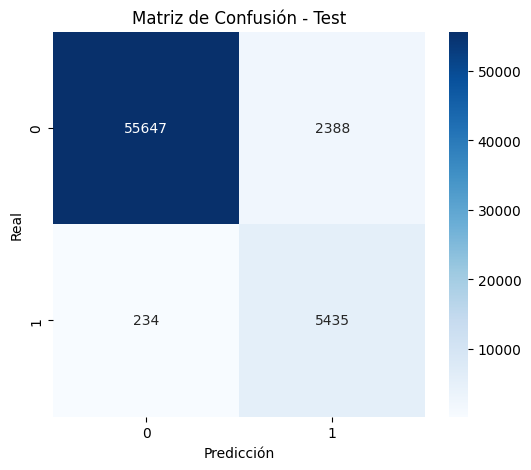

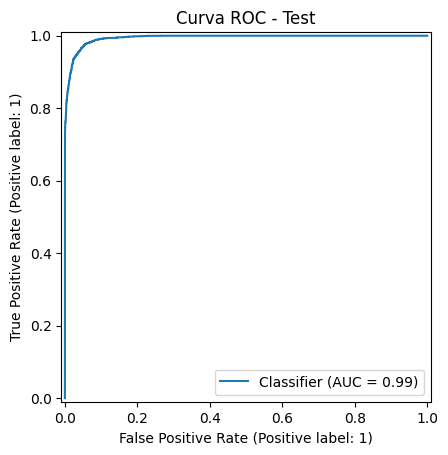

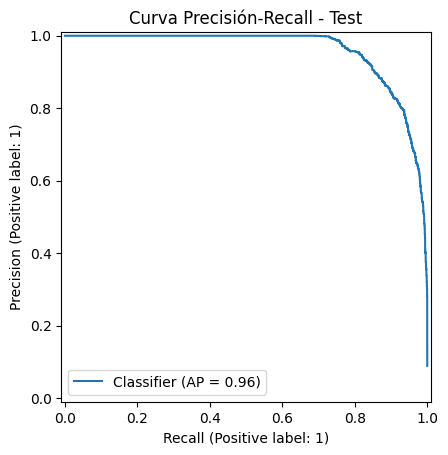

[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=1; total time=   2.5s
[CV] END learning_rate=0.01, max_depth=7, n_estimators=100, scale_pos_weight=1; total time=   2.6s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, scale_pos_weight=1; total time=   1.4s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, scale_pos_weight=10.236823537712551; total time=   1.3s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=10.236823537712551; total time=   1.8s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=1; total time=   1.4s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=100, scale_pos_weight=1; total time=   1.8s
[CV] END learning_rate=0.01, max_depth=7, n_estimators=100, scale_pos_weight=1; total time=   2.3s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, scale_pos_weight=10.236823537712551; total time=   1.5s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=100, sca

In [23]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Predicciones y probabilidades
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Informe de clasificación
print("\n📊 Informe de clasificación sobre conjunto de test real:\n")
print(classification_report(y_test, y_pred, digits=3))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión - Test")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# ROC Curve
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("Curva ROC - Test")
plt.show()

# Curva Precision-Recall
PrecisionRecallDisplay.from_predictions(y_test, y_proba)
plt.title("Curva Precisión-Recall - Test")
plt.show()

El modelo XGBoost fue evaluado inicialmente mediante un enfoque de ensemble por submuestreo con optimización de hiperparámetros, generando un rendimiento notablemente alto en el conjunto completo de datos. El informe inicial de clasificación revela una precisión del 99.6% para la clase mayoritaria y del 72.7% para la minoritaria, con una puntuación F1 de 0.980 y 0.828, respectivamente. El promedio ponderado del F1-score alcanzó un 0.967 y la precisión general (accuracy) se situó en un excelente 96.4%. Estas métricas sugieren una fuerte capacidad del modelo para distinguir entre clases, especialmente considerando el desequilibrio del dataset.

No obstante, para validar la capacidad de generalización del modelo, se procedió a una evaluación adicional mediante validación cruzada estratificada (5 particiones), seguida de la evaluación en un conjunto de prueba real previamente separado. En esta fase, las métricas sufrieron un ligero deterioro. El informe de clasificación en el conjunto de test muestra una precisión del 99.6% para la clase negativa (no churn) y del 69.5% para la clase positiva (churn), con un F1-score de 0.977 y 0.805, respectivamente. La caída en la precisión para la clase minoritaria indica una mayor tasa de falsos positivos. Esto también se refleja en la matriz de confusión, donde se observa un número no despreciable de instancias de clase negativa incorrectamente clasificadas como positivas (2.388 casos).

A pesar de este ajuste, el modelo mantiene excelentes resultados globales: una curva ROC-AUC de 0.99 y una media de precisión (AP) en la curva precisión-recall de 0.96. Estas curvas reflejan que, en términos de clasificación binaria probabilística, XGBoost sigue mostrando una capacidad sobresaliente para priorizar correctamente las predicciones positivas. Sin embargo, el descenso en precisión y F1 para la clase de interés (churn) durante la validación indica que el modelo presenta cierto sobreajuste al conjunto de entrenamiento original.

En resumen, aunque el modelo XGBoost ha demostrado un rendimiento global excelente y competitivo, tanto en entrenamiento como en test, los resultados validan la necesidad de una evaluación cruzada rigurosa. Esta permitió detectar un leve sobreajuste, evidenciado principalmente en la menor precisión sobre la clase minoritaria. Aun así, el balance entre recall elevado y una aún aceptable precisión convierte a XGBoost en una opción robusta para problemas de clasificación con clases desbalanceadas, especialmente cuando se prioriza la detección de eventos positivos (churn). Se recomienda, no obstante, considerar un ajuste fino adicional o el uso de técnicas de calibración si el modelo se implementará en entornos sensibles al coste de falsos positivos.


### LightBoost

In [20]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib

# -----------------------------
# Configuración general
# -----------------------------
n_estimators = 5
random_seed = 42
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)

# Pipeline de preprocesamiento y modelo
pipeline_lgbm = Pipeline([
    ("scaler", StandardScaler()),
    ("lgbm", LGBMClassifier(random_state=random_seed))
])

# Rejilla de hiperparámetros
param_grid = {
    "lgbm__n_estimators": [100],
    "lgbm__num_leaves": [31, 63],
    "lgbm__learning_rate": [0.05, 0.1],
    "lgbm__class_weight": [None, "balanced"]
}

# -----------------------------
# División por clase
# -----------------------------
X_majority = X_scaled[y == 0]
X_minority = X_scaled[y == 1]
y_majority = y[y == 0]
y_minority = y[y == 1]

# -----------------------------
# Ensemble por submuestreo
# -----------------------------
models = []
predictions = []

for i in range(n_estimators):
    # Submuestreo de la clase mayoritaria
    X_major_sub, y_major_sub = resample(
        X_majority, y_majority,
        replace=False,
        n_samples=len(y_minority),
        random_state=random_seed + i
    )

    # Conjunto balanceado
    X_train_balanced = np.vstack((X_major_sub, X_minority))
    y_train_balanced = np.concatenate((y_major_sub, y_minority))

    # Búsqueda de hiperparámetros
    grid = GridSearchCV(
        estimator=pipeline_lgbm,
        param_grid=param_grid,
        scoring="f1",
        cv=cv,
        n_jobs=-1,
        verbose=2
    )
    grid.fit(X_train_balanced, y_train_balanced)

    # Guardar mejor modelo y predicciones
    best_model = grid.best_estimator_
    models.append(best_model)
    probas = best_model.predict_proba(X_scaled)[:, 1]
    predictions.append(probas)

# -----------------------------
# Ensamble final y evaluación
# -----------------------------
ensemble_proba = np.mean(predictions, axis=0)
ensemble_pred = (ensemble_proba >= 0.5).astype(int)

print("\n🔍 Informe final del ensemble con LightGBM:\n")
print(classification_report(y, ensemble_pred, digits=3))

# Guardar el ensemble
joblib.dump(models, "lightgbm_ensemble_models.pkl")
print("✅ Modelos LightGBM guardados como 'lightgbm_ensemble_models.pkl'")


Fitting 5 folds for each of 8 candidates, totalling 40 fits


/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does 

[LightGBM] [Info] Number of positive: 28346, number of negative: 28346
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 638
[LightGBM] [Info] Number of data points in the train set: 56692, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fitting 5 folds for each of 8 candidates, totalling 40 fits


/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does 

[LightGBM] [Info] Number of positive: 22677, number of negative: 22676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 3.318034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 638
[LightGBM] [Info] Number of data points in the train set: 45353, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500011 -> initscore=0.000044
[LightGBM] [Info] Start training from score 0.000044
[CV] END lgbm__class_weight=None, lgbm__learning_rate=0.1, lgbm__n_estimators=100, lgbm__num_leaves=31; total time=18.5min
[LightGBM] [Info] Number of positive: 22677, number of negative: 22677
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.320783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total B

/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does 

[LightGBM] [Info] Number of positive: 22676, number of negative: 22677
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 3.642790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 638
[LightGBM] [Info] Number of data points in the train set: 45353, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499989 -> initscore=-0.000044
[LightGBM] [Info] Start training from score -0.000044
[CV] END lgbm__class_weight=None, lgbm__learning_rate=0.05, lgbm__n_estimators=100, lgbm__num_leaves=63; total time=23.7min
[LightGBM] [Info] Number of positive: 22676, number of negative: 22677
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.212390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Tota

/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 22676, number of negative: 22677
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 4.144041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 638
[LightGBM] [Info] Number of data points in the train set: 45353, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499989 -> initscore=-0.000044
[LightGBM] [Info] Start training from score -0.000044
[CV] END lgbm__class_weight=None, lgbm__learning_rate=0.05, lgbm__n_estimators=100, lgbm__num_leaves=31; total time=18.6min
[LightGBM] [Info] Number of positive: 22677, number of negative: 22677
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.821602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Tota

/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 28346, number of negative: 28346
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 638
[LightGBM] [Info] Number of data points in the train set: 56692, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fitting 5 folds for each of 8 candidates, totalling 40 fits


/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does 

[LightGBM] [Info] Number of positive: 22676, number of negative: 22677
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.560187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 638
[LightGBM] [Info] Number of data points in the train set: 45353, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499989 -> initscore=-0.000044
[LightGBM] [Info] Start training from score -0.000044
[CV] END lgbm__class_weight=None, lgbm__learning_rate=0.1, lgbm__n_estimators=100, lgbm__num_leaves=31; total time=18.6min
[LightGBM] [Info] Number of positive: 22677, number of negative: 22676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.462801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total

/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does 

[LightGBM] [Info] Number of positive: 22677, number of negative: 22677
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.914687 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 638
[LightGBM] [Info] Number of data points in the train set: 45354, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[CV] END lgbm__class_weight=None, lgbm__learning_rate=0.05, lgbm__n_estimators=100, lgbm__num_leaves=63; total time=38.7min
[LightGBM] [Info] Number of positive: 22677, number of negative: 22677
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 3.291784 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 638
[LightGBM] [Info] Number of data points in t

/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does 

[LightGBM] [Info] Number of positive: 28346, number of negative: 28346
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 638
[LightGBM] [Info] Number of data points in the train set: 56692, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.824178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 638
[LightGBM] [Info] Number of data points in the train set: 45354, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[CV] END lgbm__class_weight=balanced, lgbm__learning_rate=0.05, lgbm__n_estimators=100, lgbm__num_leaves=63; total time=23.9min


/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[LightGBM] [Info] Number of positive: 22677, number of negative: 22676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 3.022739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 638
[LightGBM] [Info] Number of data points in the train set: 45353, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500011 -> initscore=0.000044
[LightGBM] [Info] Start training from score 0.000044
[CV] END lgbm__class_weight=None, lgbm__learning_rate=0.05, lgbm__n_estimators=100, lgbm__num_leaves=31; total time=19.1min
[LightGBM] [Info] Number of positive: 22677, number of negative: 22677
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.077763 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does 

[LightGBM] [Info] Number of positive: 22677, number of negative: 22677
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 4.407605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 638
[LightGBM] [Info] Number of data points in the train set: 45354, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[CV] END lgbm__class_weight=None, lgbm__learning_rate=0.05, lgbm__n_estimators=100, lgbm__num_leaves=63; total time=23.7min
[LightGBM] [Info] Number of positive: 22677, number of negative: 22677
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.643816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 638
[LightGBM] [Info] Number of data points in t

/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 22677, number of negative: 22676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 3.579872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 638
[LightGBM] [Info] Number of data points in the train set: 45353, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500011 -> initscore=0.000044
[LightGBM] [Info] Start training from score 0.000044
[CV] END lgbm__class_weight=None, lgbm__learning_rate=0.05, lgbm__n_estimators=100, lgbm__num_leaves=63; total time=18.5min
[LightGBM] [Info] Number of positive: 22676, number of negative: 22677
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.629501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total 

/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does 

[LightGBM] [Info] Number of data points in the train set: 45354, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[CV] END lgbm__class_weight=balanced, lgbm__learning_rate=0.1, lgbm__n_estimators=100, lgbm__num_leaves=31; total time=22.1min
[LightGBM] [Info] Number of positive: 22677, number of negative: 22677
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 3.283191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 638
[LightGBM] [Info] Number of data points in the train set: 45354, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[CV] END lgbm__class_weight=None, lgbm__learning_rate=0.05, lgbm__n_estimators=100, lgbm__num_leaves=63; total time=28.5min
[LightGBM] [Info] Number of positive: 22677, number of negative: 22677
[Lig

/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does 

[LightGBM] [Info] Number of positive: 28346, number of negative: 28346
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.792955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 638
[LightGBM] [Info] Number of data points in the train set: 56692, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fitting 5 folds for each of 8 candidates, totalling 40 fits


/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 22677, number of negative: 22677
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 3.425755 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 638
[LightGBM] [Info] Number of data points in the train set: 45354, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[CV] END lgbm__class_weight=None, lgbm__learning_rate=0.05, lgbm__n_estimators=100, lgbm__num_leaves=63; total time=20.1min
[LightGBM] [Info] Number of positive: 22677, number of negative: 22677
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.873831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 638
[LightGBM] [Info] Number of data points in t

/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does 

[LightGBM] [Info] Number of positive: 22677, number of negative: 22677
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.176072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 638
[LightGBM] [Info] Number of data points in the train set: 45354, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[CV] END lgbm__class_weight=None, lgbm__learning_rate=0.05, lgbm__n_estimators=100, lgbm__num_leaves=31; total time=13.2min
[LightGBM] [Info] Number of positive: 22677, number of negative: 22677
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 3.145087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 638
[LightGBM] [Info] Number of data points in t

/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does 

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[CV] END lgbm__class_weight=balanced, lgbm__learning_rate=0.1, lgbm__n_estimators=100, lgbm__num_leaves=31; total time=23.4min
[LightGBM] [Info] Number of positive: 22677, number of negative: 22677
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.620032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 638
[LightGBM] [Info] Number of data points in the train set: 45354, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[CV] END lgbm__class_weight=balanced, lgbm__learning_rate=0.1, lgbm__n_estimators=100, lgbm__num_leaves=63; total time= 7.4min
[LightGBM] [Info] Number of positive: 22677, number of negative: 22677
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.534771

/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 22677, number of negative: 22676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 3.050448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 638
[LightGBM] [Info] Number of data points in the train set: 45353, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500011 -> initscore=0.000044
[LightGBM] [Info] Start training from score 0.000044
[CV] END lgbm__class_weight=None, lgbm__learning_rate=0.1, lgbm__n_estimators=100, lgbm__num_leaves=31; total time=16.8min
[LightGBM] [Info] Number of positive: 22677, number of negative: 22677
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 3.622803 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total B

/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 22677, number of negative: 22676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.871527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 638
[LightGBM] [Info] Number of data points in the train set: 45353, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500011 -> initscore=0.000044
[LightGBM] [Info] Start training from score 0.000044
[CV] END lgbm__class_weight=None, lgbm__learning_rate=0.1, lgbm__n_estimators=100, lgbm__num_leaves=31; total time=16.4min
[LightGBM] [Info] Number of positive: 22676, number of negative: 22677
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.790313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total B

/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does 

[LightGBM] [Info] Number of positive: 28346, number of negative: 28346
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 56692, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🔍 Informe final del ensemble con LightGBM:

              precision    recall  f1-score   support

         0.0      1.000     0.989     0.994    290173
         1.0      0.895     0.996     0.943     28346

    accuracy                          0.989    318519
   macro avg      0.947     0.992     0.968    318519
weighted avg      0.990     0.989     0.989    318519

✅ Modelos LightGBM guardados como 'lightgbm_ensemble_models.pkl'
[LightGBM] [Info] Number of positive: 22676, number of negative: 22677
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.451581 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 638
[LightGBM] [Info] Number of data points in the train set: 45353, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499989 -> initscore=-0.000044
[LightGBM] [Info] Start training from score -0.000044
[CV] E

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Validación cruzada con el pipeline y parámetros ya definidos
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(best_model, X_scaled, y, cv=cv, scoring="f1")
print(f"F1-score promedio (CV): {scores.mean():.4f} ± {scores.std():.4f}")


[LightGBM] [Info] Number of positive: 22677, number of negative: 232138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.363217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 646
[LightGBM] [Info] Number of data points in the train set: 254815, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.088994 -> initscore=-2.325981
[LightGBM] [Info] Start training from score -2.325981


/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 22677, number of negative: 232138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.576425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 646
[LightGBM] [Info] Number of data points in the train set: 254815, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.088994 -> initscore=-2.325981
[LightGBM] [Info] Start training from score -2.325981


/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 22677, number of negative: 232138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.363759 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 646
[LightGBM] [Info] Number of data points in the train set: 254815, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.088994 -> initscore=-2.325981
[LightGBM] [Info] Start training from score -2.325981


/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 22676, number of negative: 232139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021403 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 646
[LightGBM] [Info] Number of data points in the train set: 254815, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.088990 -> initscore=-2.326029
[LightGBM] [Info] Start training from score -2.326029


/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 22677, number of negative: 232139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.281119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 646
[LightGBM] [Info] Number of data points in the train set: 254816, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.088994 -> initscore=-2.325985
[LightGBM] [Info] Start training from score -2.325985


/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


F1-score promedio (CV): 0.9676 ± 0.0018


In [22]:
from sklearn.model_selection import train_test_split

# Separación del dataset original
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/lacpoutas/Escritorio/Grado_IA/Curso_II/Cuatrimestre_II/Machine_learning/Feedback_01/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature nam


📊 Informe de clasificación sobre conjunto de test real:

              precision    recall  f1-score   support

         0.0      1.000     0.989     0.994     58035
         1.0      0.897     0.996     0.944      5669

    accuracy                          0.989     63704
   macro avg      0.948     0.992     0.969     63704
weighted avg      0.990     0.989     0.990     63704



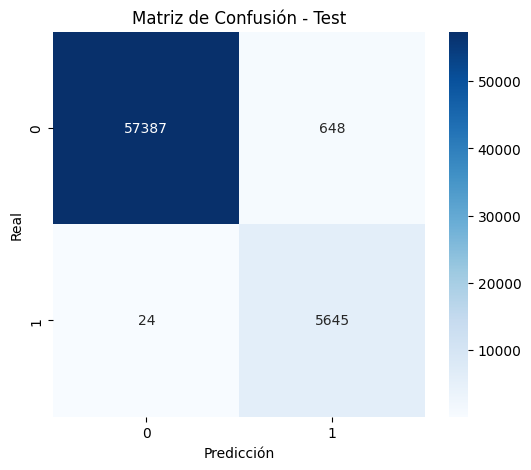

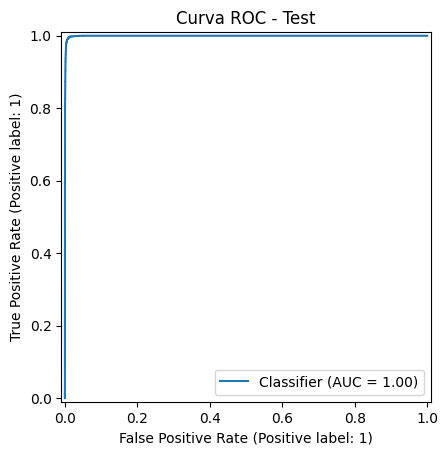

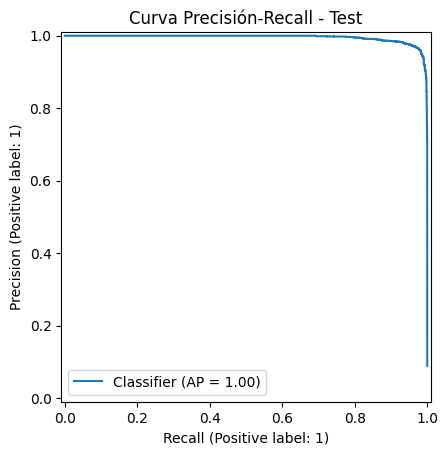

In [23]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Predicciones y probabilidades
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Informe de clasificación
print("\n📊 Informe de clasificación sobre conjunto de test real:\n")
print(classification_report(y_test, y_pred, digits=3))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión - Test")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# ROC Curve
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("Curva ROC - Test")
plt.show()

# Curva Precision-Recall
PrecisionRecallDisplay.from_predictions(y_test, y_proba)
plt.title("Curva Precisión-Recall - Test")
plt.show()